In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

## Utils

In [3]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets retrieval & transformation

In [4]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  1489
2015-01-01 2015-01-07
2015-01-08 2015-01-14
2015-01-15 2015-01-21
2015-01-22 2015-01-28
2015-01-29 2015-02-04
2015-02-05 2015-02-11
2015-02-12 2015-02-18
2015-02-19 2015-02-25
2015-02-26 2015-03-04
2015-03-05 2015-03-11
2015-03-12 2015-03-18
2015-03-19 2015-03-25
2015-03-26 2015-04-01
2015-04-02 2015-04-08
2015-04-09 2015-04-15
2015-04-16 2015-04-22
2015-04-23 2015-04-29
2015-04-30 2015-05-06
2015-05-07 2015-05-13
2015-05-14 2015-05-20
2015-05-21 2015-05-27
2015-05-28 2015-06-03
2015-06-04 2015-06-10
2015-06-11 2015-06-17
2015-06-18 2015-06-24
2015-06-25 2015-07-01
2015-07-02 2015-07-08
2015-07-09 2015-07-15
2015-07-16 2015-07-22
2015-07-23 2015-07-29
2015-07-30 2015-08-05
2015-08-06 2015-08-12
2015-08-13 2015-08-19
2015-08-20 2015-08-26
2015-08-27 2015-09-02
2015-09-03 2015-09-09
2015-09-10 2015-09-16
2015-09-17 2015-09-23
2015-09-24 2015-09-30
2015-10-01 2015-10-07
2015-10-08 2015-10-14
2015-10-15 2015-10-21
2015-10-22 2015-10-28
2015-10-29 2015-11-04
2015-11-05 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30499/30499 [00:03<00:00, 9741.05it/s]


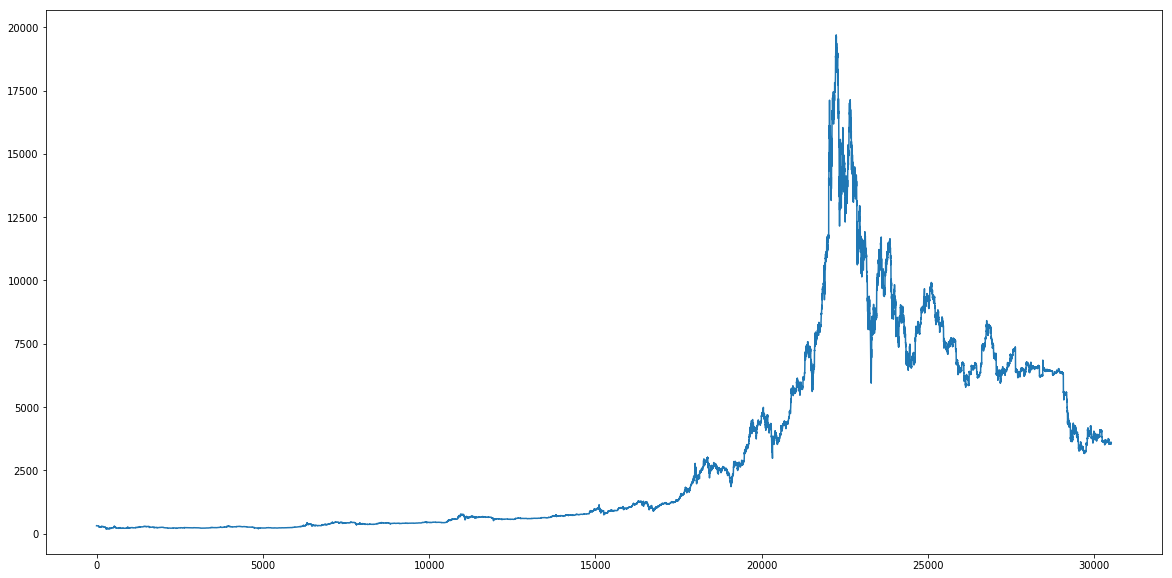

In [5]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

In [6]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 7.017790097898172%


## Simple feed-forward autoencoder

In [7]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 28499 samples, validate on 2000 samples
Epoch 1/100
28499/28499 [==============================] - ETA: 4s - loss: 0.691 - 0s 9us/step - loss: 0.6906 - val_loss: 0.6896
Epoch 2/100
28499/28499 [==============================] - ETA: 0s - loss: 0.689 - 0s 2us/step - loss: 0.6886 - val_loss: 0.6872
Epoch 3/100
28499/28499 [==============================] - ETA: 0s - loss: 0.687 - 0s 2us/step - loss: 

28499/28499 [==============================] - ETA: 0s - loss: 0.621 - 0s 2us/step - loss: 0.6216 - val_loss: 0.6198
Epoch 58/100
28499/28499 [==============================] - ETA: 0s - loss: 0.621 - 0s 1us/step - loss: 0.6212 - val_loss: 0.6193
Epoch 59/100
28499/28499 [==============================] - ETA: 0s - loss: 0.621 - 0s 1us/step - loss: 0.6209 - val_loss: 0.6189
Epoch 60/100
28499/28499 [==============================] - ETA: 0s - loss: 0.619 - 0s 1us/step - loss: 0.6205 - val_loss: 0.6184
Epoch 61/100
28499/28499 [==============================] - ETA: 0s - loss: 0.616 - 0s 1us/step - loss: 0.6202 - val_loss: 0.6180
Epoch 62/100
28499/28499 [==============================] - ETA: 0s - loss: 0.617 - 0s 1us/step - loss: 0.6199 - val_loss: 0.6177
Epoch 63/100
28499/28499 [==============================] - ETA: 0s - loss: 0.620 - 0s 1us/step - loss: 0.6196 - val_loss: 0.6173
Epoch 64/100
28499/28499 [==============================] - ETA: 0s - loss: 0.621 - 0s 2us/step - loss:

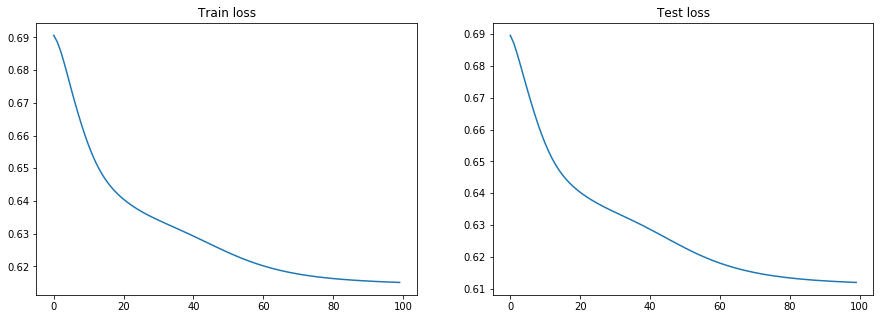

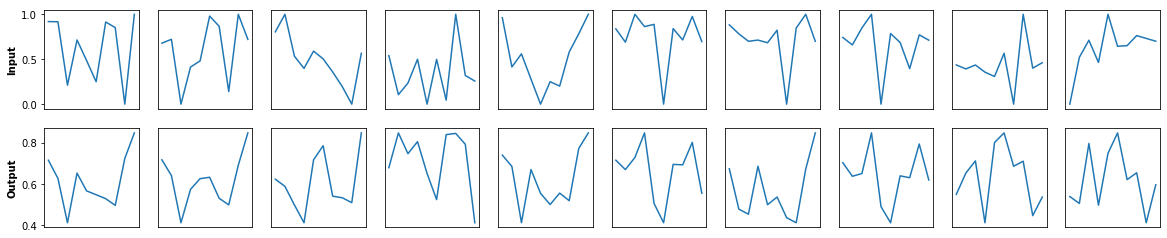

In [8]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [9]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                70        
Total para

28499/28499 [==============================] - ETA: 0s - loss: 0.614 - ETA: 0s - loss: 0.613 - 0s 3us/step - loss: 0.6135 - val_loss: 0.6109
Epoch 46/100
28499/28499 [==============================] - ETA: 0s - loss: 0.613 - ETA: 0s - loss: 0.613 - 0s 3us/step - loss: 0.6135 - val_loss: 0.6111
Epoch 47/100
28499/28499 [==============================] - ETA: 0s - loss: 0.613 - ETA: 0s - loss: 0.613 - 0s 2us/step - loss: 0.6134 - val_loss: 0.6110
Epoch 48/100
28499/28499 [==============================] - ETA: 0s - loss: 0.615 - ETA: 0s - loss: 0.613 - 0s 2us/step - loss: 0.6134 - val_loss: 0.6107
Epoch 49/100
28499/28499 [==============================] - ETA: 0s - loss: 0.614 - ETA: 0s - loss: 0.613 - 0s 2us/step - loss: 0.6134 - val_loss: 0.6107
Epoch 50/100
28499/28499 [==============================] - ETA: 0s - loss: 0.612 - ETA: 0s - loss: 0.613 - 0s 2us/step - loss: 0.6133 - val_loss: 0.6107
Epoch 51/100
28499/28499 [==============================] - ETA: 0s - loss: 0.611 - ETA: 

28499/28499 [==============================] - ETA: 0s - loss: 0.611 - ETA: 0s - loss: 0.612 - 0s 3us/step - loss: 0.6120 - val_loss: 0.6091
Epoch 99/100
28499/28499 [==============================] - ETA: 0s - loss: 0.613 - ETA: 0s - loss: 0.612 - 0s 2us/step - loss: 0.6120 - val_loss: 0.6091
Epoch 100/100
28499/28499 [==============================] - ETA: 0s - loss: 0.611 - ETA: 0s - loss: 0.612 - 0s 2us/step - loss: 0.6119 - val_loss: 0.6091


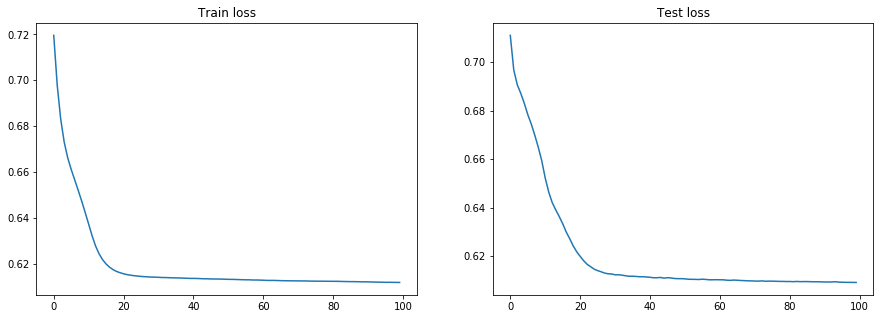

In [10]:
plot_history(history)

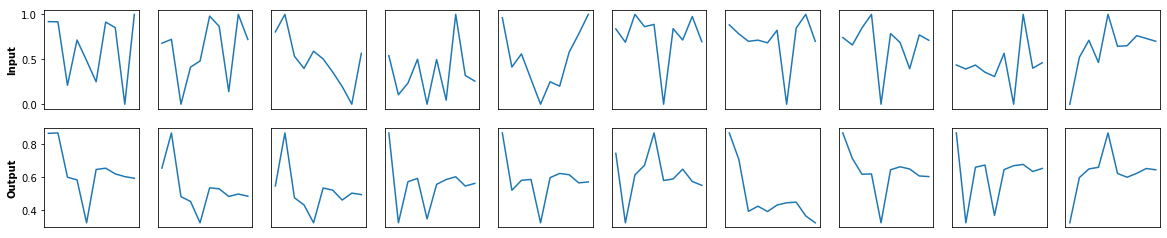

In [11]:
plot_examples(x_test_deep, decoded_stocks)

## 1D Convolutional autoencoder

In [12]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0         
__________

Epoch 29/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 30/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 31/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 32/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 33/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s 

28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 65/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 66/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 67/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930
Epoch 68/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693

Epoch 100/100
28499/28499 [==============================] - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.693 - 0s 10us/step - loss: 0.6931 - val_loss: 0.6930


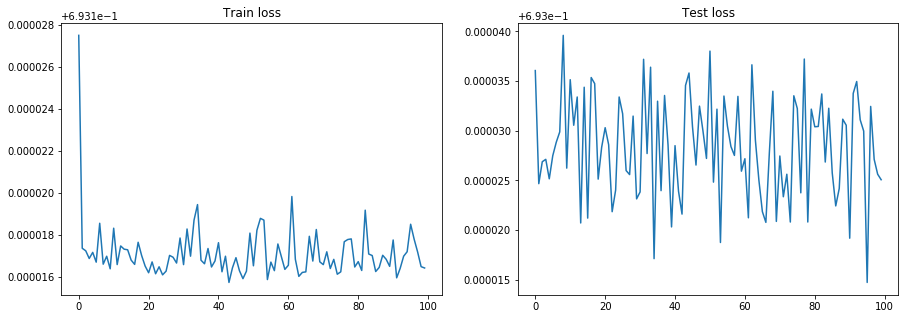

In [13]:
plot_history(history)

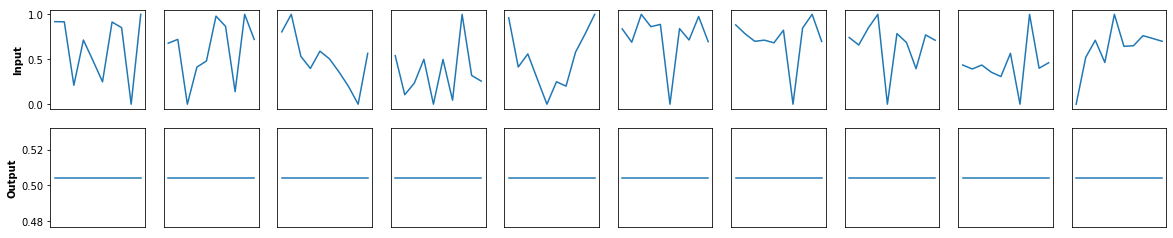

In [14]:
plot_examples(x_test_deep, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

In [15]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 3)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Train on 28499 samples, validate on 2000 samples
Epoch 1/100
28499/28499 [==============================] - ETA: 27s - loss: 8.22 - ETA: 3s - loss: 8.1593 - ETA: 1s - loss: 8.125 - ETA: 0s - loss: 8.116 - ETA: 0s - loss: 8.116 - ETA: 0s - loss: 8.118 - 1s 51us/step - loss: 8.12

28499/28499 [==============================] - ETA: 0s - loss: 8.106 - ETA: 0s - loss: 8.137 - ETA: 0s - loss: 8.139 - ETA: 0s - loss: 8.126 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 34/100
28499/28499 [==============================] - ETA: 0s - loss: 8.200 - ETA: 0s - loss: 8.130 - ETA: 0s - loss: 8.128 - ETA: 0s - loss: 8.123 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 35/100
28499/28499 [==============================] - ETA: 0s - loss: 8.117 - ETA: 0s - loss: 8.117 - ETA: 0s - loss: 8.116 - ETA: 0s - loss: 8.120 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 36/100
28499/28499 [==============================] - ETA: 0s - loss: 8.173 - ETA: 0s - loss: 8.146 - ETA: 0s - loss: 8.125 - ETA: 0s - loss: 8.129 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 37/100
28499/28499 [==============================] - ETA: 0s - loss: 8.089 - ETA: 0s - loss: 8.094 - ETA: 0s - loss: 8.110 - ETA: 0s - loss: 8.119 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epo

28499/28499 [==============================] - ETA: 0s - loss: 8.014 - ETA: 0s - loss: 8.116 - ETA: 0s - loss: 8.117 - ETA: 0s - loss: 8.119 - ETA: 0s - loss: 8.123 - 0s 9us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 71/100
28499/28499 [==============================] - ETA: 0s - loss: 8.217 - ETA: 0s - loss: 8.129 - ETA: 0s - loss: 8.144 - ETA: 0s - loss: 8.135 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 72/100
28499/28499 [==============================] - ETA: 0s - loss: 8.122 - ETA: 0s - loss: 8.114 - ETA: 0s - loss: 8.130 - ETA: 0s - loss: 8.113 - 0s 8us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 73/100
28499/28499 [==============================] - ETA: 0s - loss: 8.074 - ETA: 0s - loss: 8.114 - ETA: 0s - loss: 8.108 - ETA: 0s - loss: 8.112 - ETA: 0s - loss: 8.125 - 0s 9us/step - loss: 8.1228 - val_loss: 8.2124
Epoch 74/100
28499/28499 [==============================] - ETA: 0s - loss: 8.044 - ETA: 0s - loss: 8.090 - ETA: 0s - loss: 8.119 - ETA: 0s - loss: 8.129 - 0

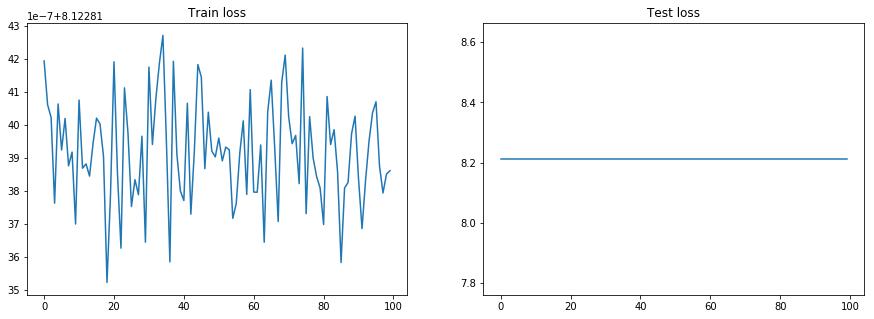

In [16]:
plot_history(history)

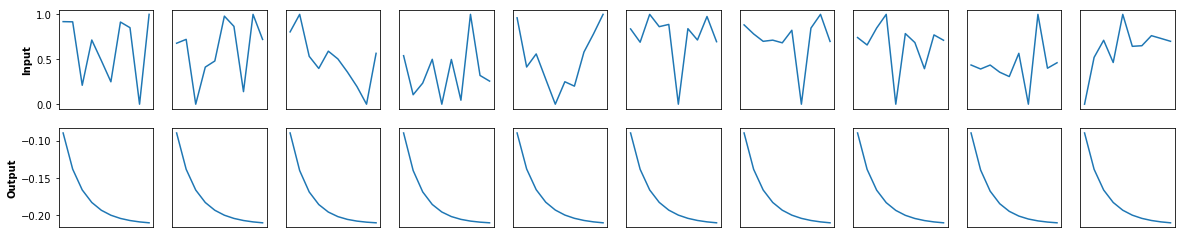

In [17]:
plot_examples(x_test, decoded_stocks)

## Simple AE + augmention with synthetic data

In [18]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 52439.37it/s]


In [19]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 128499 samples, validate on 2000 samples
Epoch 1/100
128499/128499 [==============================] - ETA: 48s - loss: 0.70 - ETA: 1s - loss: 0.6987 - ETA: 0s - loss: 0.695 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.691 - 1s 5us/step - loss: 0.6895 - val_loss: 0.6822
Epoch 2/100
128499/128499 [==============================] - ETA: 0s - loss: 0.679 - ETA: 0s - loss: 0.678 - ETA: 0s - loss: 0.677 -

128499/128499 [==============================] - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.629 - 0s 2us/step - loss: 0.6290 - val_loss: 0.6359
Epoch 34/100
128499/128499 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.629 - 0s 2us/step - loss: 0.6289 - val_loss: 0.6358
Epoch 35/100
128499/128499 [==============================] - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - 0s 2us/step - loss: 0.6288 - val_loss: 0.6356
Epoch 36/100
128499/128499 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - 0s 2us/step - loss: 0.6287 - val_loss: 0.6356
Epoch 37/100
128499/128499 [==============================] - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.628 - ETA: 0s - loss:

128499/128499 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6263 - val_loss: 0.6310
Epoch 71/100
128499/128499 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6263 - val_loss: 0.6309
Epoch 72/100
128499/128499 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6263 - val_loss: 0.6308
Epoch 73/100
128499/128499 [==============================] - ETA: 0s - loss: 0.627 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6263 - val_loss: 0.6309
Epoch 74/100
128499/128499 [==============================] - ETA: 0s - loss: 0.624 - ETA: 0s - loss:

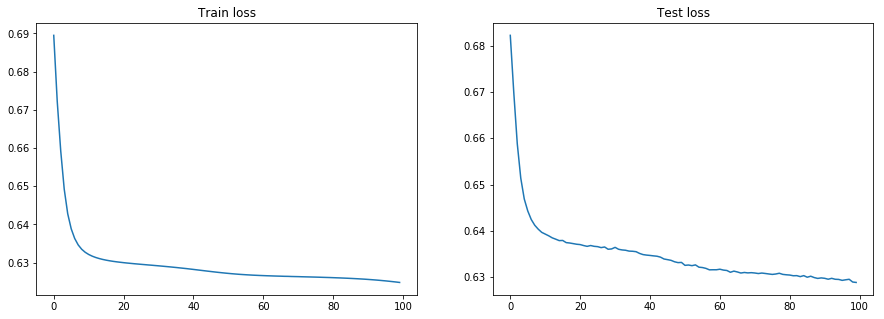

In [20]:
plot_history(history)

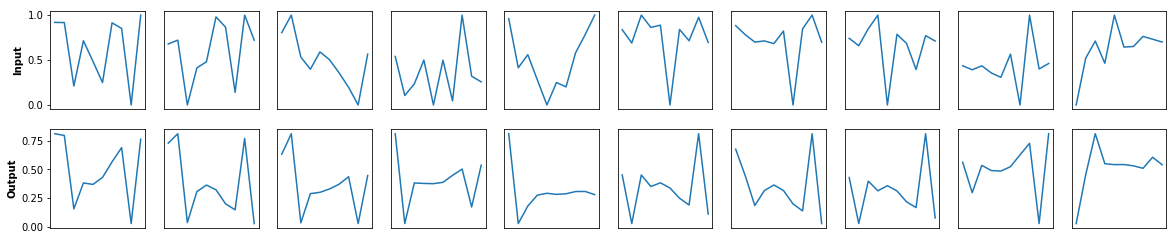

In [21]:
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder + synthetic data

In [22]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_4 (Batch (None, 6)                 24        
_________________________________________________________________
dense_12 (Dense)             (None, 10)                70        
Total para

128499/128499 [==============================] - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 3us/step - loss: 0.6228 - val_loss: 0.6278
Epoch 27/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6228 - val_loss: 0.6278
Epoch 28/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - 0s 3us/step - loss: 0.6228 - val_loss: 0.6278
Epoch 29/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA

Epoch 58/100
128499/128499 [==============================] - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6274
Epoch 59/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6275
Epoch 60/100
128499/128499 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6279
Epoch 61/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 3us/step - 

128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6278
Epoch 90/100
128499/128499 [==============================] - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6278
Epoch 91/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6275
Epoch 92/100
128499/128499 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6227 - val_loss: 0.6279
Epoch

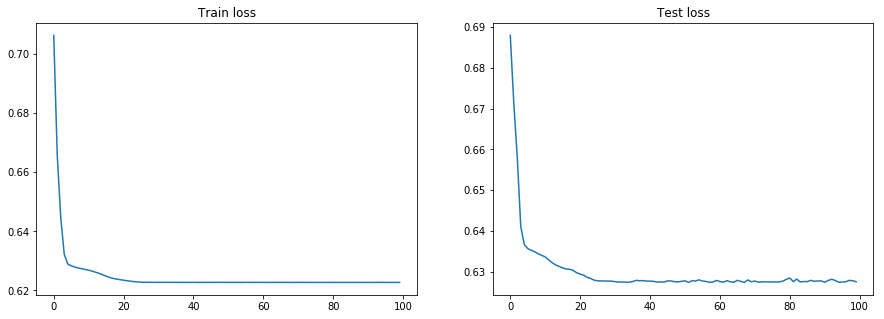

In [23]:
plot_history(history)

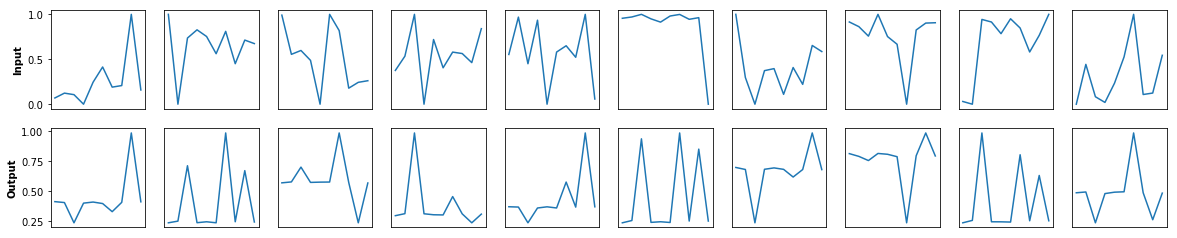

In [75]:
plot_examples(x_test_simple, decoded_stocks)